# AutoEncoder
---
自动编码器的主要应用有两个方面，第一是**数据去噪**，第二是进行**可视化降维**。自动编码器还有一个功能，即**生成数据**。

编码器和解码器可以是任意模型，通常使用神经网络模型作为编码器和解码器。

输入的数据经过神经网络降维到一个编码(code)，接着通过另外一个网络剧解码得到一个和输入原数据一模一样的生成数据，然后通过比较这两个数据，最小化它们之间的差异来训练这个网络中编码器和解码器的参数。

当这个过程训练完后，拿出这个解码器，随机传入一个编码(code)，通过解码器能够生成一个和原数据差不多的数据，

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cudAvl = lambda x : x.cuda() if torch.cuda.is_available() else x

In [3]:
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )
    
    def forward(self, x):
        code = self.encoder(x)
        imgTensor = self.decoder(code)
        return code, imgTensor
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

In [4]:
net = autoencoder()
net = cudAvl(net)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [5]:
import csv

with open('train.csv') as f :
    lines = csv.reader(f)
    label, attr = [], []
    for line in lines :
        if lines.line_num == 1 :
            continue
        label.append(int(line[0]))
        attr.append([float(j) for j in line[1:]])
print(len(label), len(attr[1]))

42000 784


In [6]:
digTensor = torch.FloatTensor(attr)
digTensor = digTensor / 255.0
digTensor.shape

torch.Size([42000, 784])

epoch [100/1500]: 0.058348119258880615
epoch [200/1500]: 0.047589220106601715
epoch [300/1500]: 0.042967937886714935
epoch [400/1500]: 0.040192779153585434
epoch [500/1500]: 0.038630422204732895
epoch [600/1500]: 0.03767261654138565
epoch [700/1500]: 0.037026435136795044
epoch [800/1500]: 0.036425597965717316
epoch [900/1500]: 0.03603523224592209
epoch [1000/1500]: 0.0356963612139225
epoch [1100/1500]: 0.035425879061222076
epoch [1200/1500]: 0.035187773406505585
epoch [1300/1500]: 0.034891996532678604
epoch [1400/1500]: 0.03473861888051033
epoch [1500/1500]: 0.034577593207359314


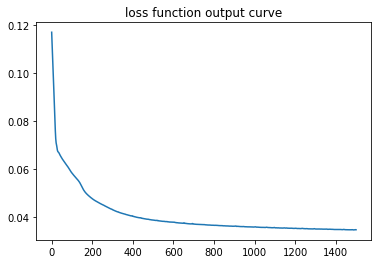

In [7]:
epoch = 1500
pltX, pltY = [], []
for e in range(epoch):
    pltX.append(e)
    Input = cudAvl(Variable(digTensor))
    Target = cudAvl(Variable(digTensor))
    _, Output = net(Input)
    loss = criterion(Output,Target)
    print_loss = loss.data[0]
    pltY.append(print_loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0:
        print('epoch [%s/%s]: %s' %(e + 1, epoch, print_loss))

plt.title('loss function output curve')
plt.plot(pltX, pltY)
plt.show()

In [8]:
from PIL import  Image
import numpy as np

def getImage(matrix):
    dig = np.array(matrix.numpy()).reshape((28, 28))
    digImg = Image.fromarray(dig * 255)
    digImg = digImg.convert('L')
    return digImg

def compare(matrix, testNet):
    before = getImage(matrix)
    plt.subplot(121)
    plt.title('before encoding')
    plt.imshow(before)
    
    matrix = matrix.unsqueeze(0)
    In = cudAvl(Variable(matrix))
    code, Out = testNet(In)
    if torch.cuda.is_available():
        Out = Out.cpu()
    after = getImage(Out.data)
    
    plt.subplot(122)
    plt.title('after encoding')
    plt.imshow(after)

image index = 36717 , number =  3 



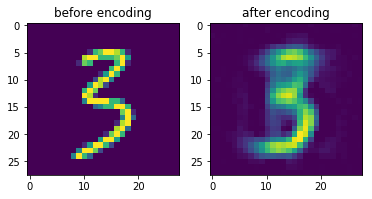

In [16]:
import random
index = random.randint(0, digTensor.shape[0])
print('image index =', index, ', number = ', label[index], '\n')

net.eval()
compare(digTensor[index], net)

效果还不错~

---

接下来试一下以**卷积神经网络**为基础的自动编码器

In [10]:
class CNNautoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        code = self.encoder(x)
        transImg = self.decoder(code)
        return code, transImg

In [11]:
CNNnet = CNNautoencoder()
CNNnet = cudAvl(CNNnet)
CNNcriterion = nn.MSELoss()
CNNoptimizer = torch.optim.Adam(CNNnet.parameters(), lr=1e-3, weight_decay=1e-5)

CNNdigTensor = digTensor.view(digTensor.shape[0], 1, 28, 28)

epoch [100/1000]: 0.06539251655340195
epoch [200/1000]: 0.05366114154458046
epoch [300/1000]: 0.04686489701271057
epoch [400/1000]: 0.042550913989543915
epoch [500/1000]: 0.0394083596765995
epoch [600/1000]: 0.03722544014453888
epoch [700/1000]: 0.03553758189082146
epoch [800/1000]: 0.034192875027656555
epoch [900/1000]: 0.03310518339276314
epoch [1000/1000]: 0.03222407400608063


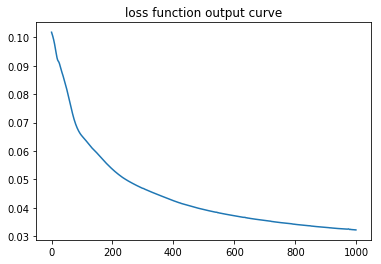

In [12]:
epoch = 1000
pltX, pltY = [], []
for e in range(epoch):
    pltX.append(e)
    Input = cudAvl(Variable(CNNdigTensor))
    Target = cudAvl(Variable(CNNdigTensor))
    _, Output = CNNnet(Input)
    loss = CNNcriterion(Output,Target)
    print_loss = loss.data[0]
    pltY.append(print_loss)
    CNNoptimizer.zero_grad()
    loss.backward()
    CNNoptimizer.step()
    if (e + 1) % 100 == 0:
        print('epoch [%s/%s]: %s' %(e + 1, epoch, print_loss))

plt.title('loss function output curve')
plt.plot(pltX, pltY)
plt.show()

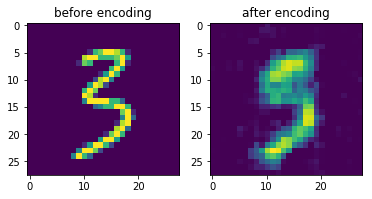

In [17]:
CNNnet.eval()
compare(CNNdigTensor[index], CNNnet)